In [7]:
# Install dependencies if needed
!pip install tqdm opencv-python

# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm.notebook import tqdm
import time
from google.colab import drive
import glob
import torch
from torch.linalg import norm as torch_norm
from torch.linalg import pinv as torch_pinv

In [8]:
# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')

# Define path to your dataset in Google Drive
root_dir = '/content/drive/MyDrive/dataset'  # Update this to your actual path
train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'test')

# Check if directories exist
print(f"Train directory exists: {os.path.exists(train_dir)}")
print(f"Test directory exists: {os.path.exists(test_dir)}")

# Setup GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Mounting Google Drive...
Mounted at /content/drive
Train directory exists: True
Test directory exists: True
Using device: cpu


In [3]:
# Parameters
patch_size = 8      # 8×8 patches
num_atoms = 100     # K
T0 = 10             # sparsity
err = 1e-4          # error tolerance
num_epochs = 100    # epochs
scale_f = 0.25      # down-sampling
stride = 16         # sample stride
torch.manual_seed(0)  # for reproducibility
np.random.seed(0)

In [14]:
def GenOMP_optimized(D, y, T0, err):
    """
    GPU-optimized Generalized Orthogonal Matching Pursuit algorithm
    """
    K = D.shape[1]
    x = torch.zeros((K, 1), device=device)

    r = y.clone()
    S = []

    # Force GPU computation by explicitly using torch operations
    while torch.norm(r).item() > err and len(S) < T0:
        # Compute correlations on GPU
        corr = torch.abs(torch.matmul(D.T, r))
        k = torch.argmax(corr).item()

        if k in S:
            break

        S.append(k)

        # Ensure all operations stay on GPU with explicit torch operations
        if len(S) > 0:
            D_S = D[:, S]
            # Use explicit torch operations
            x_S = torch.matmul(torch.linalg.pinv(D_S), y)

            r = y - torch.matmul(D_S, x_S)

            for i, idx in enumerate(S):
                x[idx] = x_S[i]

    # Force GPU synchronization to ensure completion
    torch.cuda.synchronize()

    return x

In [10]:
def KSVD(D, X, Y):
    """
    K-SVD dictionary learning algorithm with GPU support
    """
    # Verify tensors are on GPU
    assert D.device.type == 'cuda', "Dictionary tensor is not on GPU"
    assert X.device.type == 'cuda', "Sparse coefficients tensor is not on GPU"
    assert Y.device.type == 'cuda', "Signal matrix tensor is not on GPU"

    for k in range(D.shape[1]):
        # Find indices where atom k is used
        ind = torch.where(X[k, :] != 0)[0]

        if len(ind) > 0:
            # All operations on GPU
            E = Y - (D @ X) + torch.outer(D[:, k], X[k, :])
            E_r = E[:, ind]

            try:
                # Use torch.linalg functions to ensure GPU operations
                U, S, V = torch.linalg.svd(E_r, full_matrices=False)

                D[:, k] = U[:, 0]
                X[k, :] = 0
                X[k, ind] = S[0] * V[0, :]
            except Exception as e:
                print(f"SVD failed on atom {k}: {e}")
                pass

    # Force GPU synchronization to ensure operations complete
    torch.cuda.synchronize()

    return D, X

In [15]:
def DictionaryLearning_GPU(D, Y, err, T0, numEpochs, X):
    """
    GPU-optimized Dictionary Learning with batch processing
    """
    # Force tensors to correct device
    D = D.to(device)
    Y = Y.to(device)
    X = X.to(device)

    print(f"Memory after moving tensors: {torch.cuda.memory_allocated() / 1e9:.3f} GB")

    # Use numpy array for MSE (no need for GPU here)
    MSE = np.zeros(numEpochs)

    for epoch in tqdm(range(numEpochs), desc="Training epochs"):
        print(f"Epoch {epoch+1}/{numEpochs}")

        # BATCH PROCESSING: Process multiple samples in parallel
        batch_size = 50  # Adjust based on your GPU memory
        num_samples = Y.shape[1]

        for batch_start in range(0, num_samples, batch_size):
            batch_end = min(batch_start + batch_size, num_samples)
            batch_indices = list(range(batch_start, batch_end))

            # Process this batch of patches
            for i in batch_indices:
                # Ensure single column vector shape
                y_i = Y[:, i:i+1]
                X[:, i:i+1] = GenOMP_optimized(D, y_i, T0, err)

            # Periodically force synchronization
            if batch_start % 500 == 0:
                torch.cuda.synchronize()
                print(f"  Processed {batch_end}/{num_samples} patches, GPU memory: {torch.cuda.memory_allocated() / 1e9:.3f} GB")

        # Dictionary update step (K-SVD)
        print("Updating dictionary...")
        D, X = KSVD(D, X, Y)

        # Calculate error and convert to CPU for numpy
        error = Y - torch.matmul(D, X)
        MSE[epoch] = torch.norm(error, 'fro').item()**2

        print(f"MSE: {MSE[epoch]:.6f}")

        # Clear cache every epoch
        torch.cuda.empty_cache()
        print(f"GPU memory after epoch {epoch+1}: {torch.cuda.memory_allocated() / 1e9:.3f} GB")

    return MSE, D, X

In [7]:
# Training set preparation
print("Preparing training data...")
train_list = glob.glob(os.path.join(train_dir, '*.jpg'))

if len(train_list) == 0:
    raise ValueError(f"No training images found in {train_dir}")

# Get dimensions from first image
img = cv2.imread(train_list[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, None, fx=scale_f, fy=scale_f)
img = img / 255.0  # normalize to [0,1]

H, W = img.shape
max_per = len(range(0, H-patch_size+1, stride)) * len(range(0, W-patch_size+1, stride))
Y_np = np.zeros((patch_size**2, max_per*len(train_list)))

col = 0
for img_path in tqdm(train_list, desc="Processing training images"):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, None, fx=scale_f, fy=scale_f)
    img = img / 255.0  # normalize to [0,1]

    for r in range(0, H-patch_size+1, stride):
        for c in range(0, W-patch_size+1, stride):
            patch = img[r:r+patch_size, c:c+patch_size]
            v = patch.reshape(-1, 1)
            n = np.linalg.norm(v)

            if n < 1e-8:
                continue

            Y_np[:, col:col+1] = v / n
            col += 1

Y_np = Y_np[:, :col]  # Trim unused columns
print(f"Collected {col} patches from {len(train_list)} images")

# Convert to PyTorch tensors and move to GPU
Y = torch.tensor(Y_np, dtype=torch.float32, device=device)

Preparing training data...


Processing training images:   0%|          | 0/15 [00:00<?, ?it/s]

Collected 7303 patches from 15 images


In [17]:
# Print GPU information
print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Total memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
print(f"Memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

# Make sure we're starting with clean GPU memory
torch.cuda.empty_cache()
print(f"Memory after clearing cache: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

# Initialize dictionary and sparse representation
D_np = np.random.randn(patch_size**2, num_atoms)
D_np = D_np / np.linalg.norm(D_np, axis=0)
D = torch.tensor(D_np, dtype=torch.float32, device=device)

X = torch.zeros((num_atoms, Y.shape[1]), dtype=torch.float32, device=device)

# Verify tensors are on GPU
print(f"D is on GPU: {D.is_cuda}")
print(f"X is on GPU: {X.is_cuda}")
print(f"Y is on GPU: {Y.is_cuda}")

# Full training with 100 epochs
print("\nStarting full training with 100 epochs...")
start_time = time.time()
MSE, D, X = DictionaryLearning_GPU(D, Y, err, T0, num_epochs, X)
elapsed_time = time.time() - start_time
print(f"Total time: {elapsed_time:.1f} sec")

# Convert back to numpy for saving
D_np = D.cpu().numpy()
X_np = X.cpu().numpy()

# Save trained dictionary and MSE
np.save('/content/drive/MyDrive/D_trained.npy', D_np)
np.save('/content/drive/MyDrive/MSE_vec.npy', MSE)

GPU: Tesla T4
Total memory: 15.83 GB
Memory allocated: 0.02 GB
Memory after clearing cache: 0.02 GB
D is on GPU: True
X is on GPU: True
Y is on GPU: True

Starting full training with 100 epochs...
Memory after moving tensors: 0.023 GB


Training epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100
  Processed 50/7303 patches, GPU memory: 0.023 GB
  Processed 550/7303 patches, GPU memory: 0.023 GB
  Processed 1050/7303 patches, GPU memory: 0.023 GB
  Processed 1550/7303 patches, GPU memory: 0.023 GB
  Processed 2050/7303 patches, GPU memory: 0.023 GB
  Processed 2550/7303 patches, GPU memory: 0.023 GB
  Processed 3050/7303 patches, GPU memory: 0.023 GB
  Processed 3550/7303 patches, GPU memory: 0.023 GB
  Processed 4050/7303 patches, GPU memory: 0.023 GB
  Processed 4550/7303 patches, GPU memory: 0.023 GB
  Processed 5050/7303 patches, GPU memory: 0.023 GB
  Processed 5550/7303 patches, GPU memory: 0.023 GB
  Processed 6050/7303 patches, GPU memory: 0.023 GB
  Processed 6550/7303 patches, GPU memory: 0.023 GB
  Processed 7050/7303 patches, GPU memory: 0.023 GB
Updating dictionary...
MSE: 468.327630
GPU memory after epoch 1: 0.025 GB
Epoch 2/100
  Processed 50/7303 patches, GPU memory: 0.025 GB
  Processed 550/7303 patches, GPU memory: 0.025 GB
  Processed 1050/7303 pa

Loading MSE from saved file...


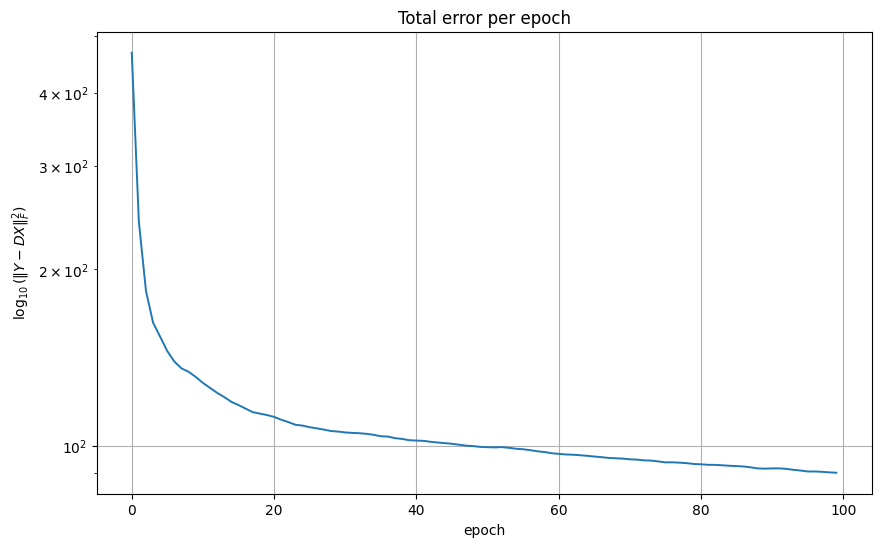

<Figure size 640x480 with 0 Axes>

In [9]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt

# Load MSE from file
print("Loading MSE from saved file...")
MSE = np.load('/content/drive/MyDrive/MSE_vec.npy')

# Plot MSE
plt.figure(figsize=(10, 6))
plt.semilogy(MSE, linewidth=1.4)
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel(r'$\log_{10}(\|Y-DX\|_F^2)$')
plt.title('Total error per epoch')
plt.show()

# Save the figure
plt.savefig('/content/drive/MyDrive/MSE_plot.png', dpi=300, bbox_inches='tight')

Loading dictionary from saved file...


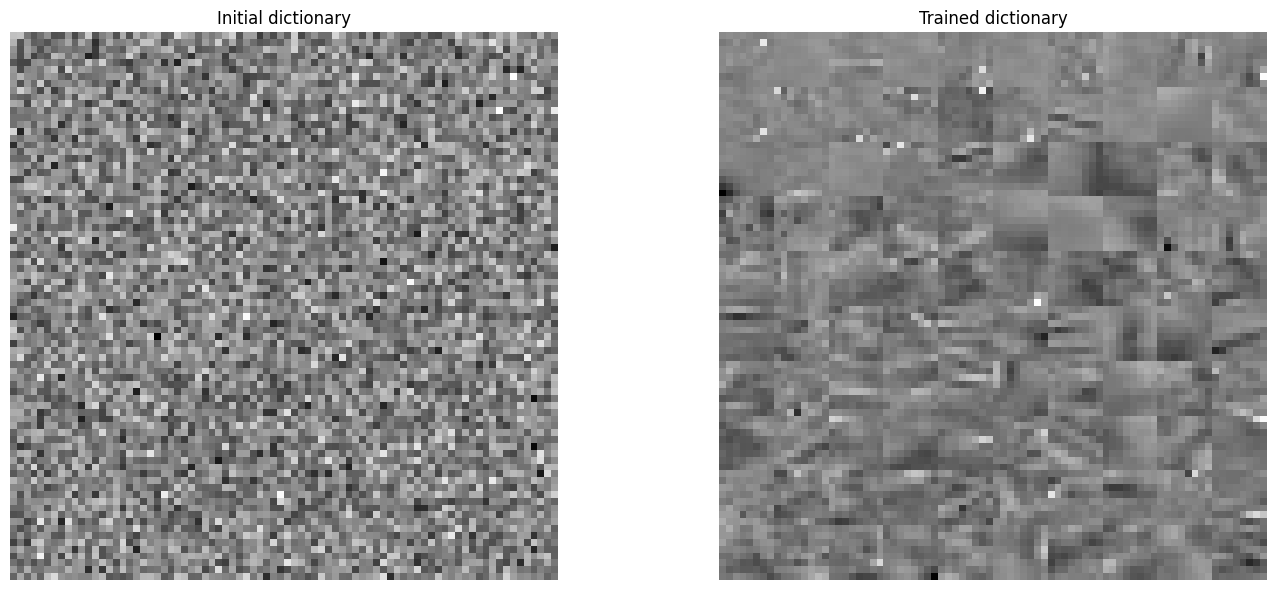

<Figure size 640x480 with 0 Axes>

In [11]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np

# Define parameters (in case they're not in memory)
try:
    # Check if parameters are defined
    _ = patch_size
except NameError:
    # Define parameters again
    patch_size = 8
    num_atoms = 100

# Load D_np if it's not already in memory
try:
    # Try to use D_np from memory
    _ = D_np.shape  # This will raise NameError if D_np is not defined
except NameError:
    # If D_np is not in memory, load it from file
    print("Loading dictionary from saved file...")
    D_np = np.load('/content/drive/MyDrive/D_trained.npy')

# Visualize dictionary evolution
np.random.seed(0)
D0_np = np.random.randn(patch_size**2, num_atoms)
D0_np = D0_np / np.linalg.norm(D0_np, axis=0)

plt.figure(figsize=(15, 6))

# Initial dictionary
plt.subplot(1, 2, 1)
D0_vis = np.zeros((10*patch_size, 10*patch_size))
for i in range(10):
    for j in range(10):
        if i*10 + j < num_atoms:
            atom = D0_np[:, i*10 + j].reshape(patch_size, patch_size)
            D0_vis[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = atom
plt.imshow(D0_vis, cmap='gray')
plt.title('Initial dictionary')
plt.axis('off')

# Trained dictionary
plt.subplot(1, 2, 2)
D_vis = np.zeros((10*patch_size, 10*patch_size))
for i in range(10):
    for j in range(10):
        if i*10 + j < num_atoms:
            atom = D_np[:, i*10 + j].reshape(patch_size, patch_size)
            D_vis[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = atom
plt.imshow(D_vis, cmap='gray')
plt.title('Trained dictionary')
plt.axis('off')

plt.tight_layout()
plt.show()

# Save the figure
plt.savefig('/content/drive/MyDrive/dictionary_evolution.png', dpi=300, bbox_inches='tight')

In [16]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import glob
import torch

# Define parameters if not already defined
try:
    # Check if parameters exist
    _ = patch_size, scale_f, T0, err
except NameError:
    # Define parameters
    patch_size = 8
    scale_f = 0.25
    T0 = 10
    err = 1e-4

# Force CPU usage to avoid CUDA issues
os.environ["CUDA_VISIBLE_DEVICES"] = ""
device = torch.device("cpu")
print(f"Using device: {device}")

# Define CPU version of GenOMP
def GenOMP_cpu(D, y, T0, err):
    """Generalized OMP for CPU only"""
    K = D.shape[1]
    x = torch.zeros((K, 1))

    r = y.clone()
    S = []

    while torch.norm(r).item() > err and len(S) < T0:
        corr = torch.abs(torch.matmul(D.T, r))
        k = torch.argmax(corr).item()

        if k in S:
            break

        S.append(k)

        if len(S) > 0:
            D_S = D[:, S]
            x_S = torch.matmul(torch.linalg.pinv(D_S), y)

            r = y - torch.matmul(D_S, x_S)

            for i, idx in enumerate(S):
                x[idx] = x_S[i]

    return x

# Testing
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))
print("\nReconstruction MSE on test set:")

if len(test_list) == 0:
    raise ValueError(f"No test images found in {test_dir}")

# Load the trained dictionary to CPU
D = torch.tensor(D_np, dtype=torch.float32)

# Prepare to store reconstruction results
all_results = []

for img_path in test_list:
    img_name = os.path.basename(img_path)

    # Load and preprocess image
    Iorig = cv2.imread(img_path)
    Iorig = cv2.cvtColor(Iorig, cv2.COLOR_BGR2GRAY)
    Iorig = cv2.resize(Iorig, None, fx=scale_f, fy=scale_f)
    Iorig = Iorig / 255.0

    H, W = Iorig.shape
    Irec = np.zeros((H, W))

    # Process each patch
    for r in range(0, H-patch_size+1, patch_size):
        for c in range(0, W-patch_size+1, patch_size):
            patch = Iorig[r:r+patch_size, c:c+patch_size]
            vec = patch.reshape(-1, 1)
            nrm = np.linalg.norm(vec)

            if nrm < 1e-8:
                nrm = 1

            # Process on CPU
            vec_tensor = torch.tensor(vec/nrm, dtype=torch.float32)

            # Get sparse representation
            coeff = GenOMP_cpu(D, vec_tensor, T0, err)

            # Convert to numpy
            coeff_np = coeff.numpy()

            # Reconstruct patch
            patch_rec = (D_np @ coeff_np).reshape(patch_size, patch_size) * nrm
            Irec[r:r+patch_size, c:c+patch_size] = patch_rec

    # Compute MSE
    mse = np.mean((Iorig - Irec)**2)
    all_results.append({'name': img_name, 'mse': mse})
    print(f"  {img_name:<12}  {mse:.5f}")

    # Visualize original and reconstructed images
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(Iorig, cmap='gray')
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(Irec, cmap='gray')
    plt.title('Reconstruction')
    plt.axis('off')

    plt.suptitle(f'{img_name} (MSE: {mse:.5f})')
    plt.tight_layout()
    plt.show()

    # Save the reconstructed image
    plt.savefig(f'/content/drive/MyDrive/recon_{img_name}.png', dpi=300, bbox_inches='tight')

    # Also save the reconstructed image as array
    np.save(f'/content/drive/MyDrive/recon_{os.path.splitext(img_name)[0]}.npy', Irec)

# Save all MSE results to file
import pandas as pd
results_df = pd.DataFrame(all_results)
results_df.to_csv('/content/drive/MyDrive/test_results.csv', index=False)
print("\nTest results saved to CSV file.")

Output hidden; open in https://colab.research.google.com to view.